In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/MyDrive/5153")

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
df = pd.read_csv('movie_variable_full.csv')
df.head(1)

,id,tconst,titleType,primaryTitle,originalTitle,startYear,release_date,isAdult,genres,runtime,budget,original_language,overview,popularity,poster_path,production_companies,production_countries,revenue,status,vote_average,vote_count,averageRating,numVotes,director,actor
0,16612,tt0000001,short,Carmencita,Carmencita,1894.0,1894-03-14,0,"Documentary,Short",1.0,0,en,The first woman to appear in front of an Ediso...,1.273072,/6QJowxF4f2hrUtmrDXOqbRDMdDH.jpg,Edison Manufacturing Company,US,0.0,Released,4.9,18.0,5.6,1550.0,William K.L. Dickson,Carmencita


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
len(df)

45307

# Download poster data through URL

In [ ]:
poster_L = df.poster_path.values
id_L = df.id.values
for i in range(13557, len(df)):
  if (i+1)%5000 == 0:
    print(i+1, 'done.')
  img_src = 'https://image.tmdb.org/t/p/w200' + poster_L[i]
  ID = id_L[i]
  cap = cv2.VideoCapture(img_src)
  if( cap.isOpened() ) :
      ret,img = cap.read()
      cv2.imwrite("./poster/" + str(ID) + ".png", img)

15000 done.
20000 done.
25000 done.
30000 done.
35000 done.
40000 done.
45000 done.


In [ ]:
files= os.listdir('./poster')
len(files)

5713

In [ ]:
d = df.copy()
pic = [int(i[:-4]) for i in files]
d = d[d['id'].isin(pic)]
d.sort_values('id',inplace = True)
d.set_index('id',inplace = True)
# d.to_csv('poster_data.csv')

In [ ]:
data = df[['id','averageRating']].copy()
data.head()

,id,averageRating
0,16612,5.6
1,88013,6.5
2,16624,6.1
3,105158,5.4
4,774,6.9


In [ ]:
pic = [int(i[:-4]) for i in files]
data = data[data['id'].isin(pic)]
data.sort_values('id',inplace = True)
data.set_index('id',inplace = True)
data.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,averageRating
id,
67,7.4
76,8.1
80,8.0
92,7.5
99,7.8


In [ ]:
len(data)

5713

In [ ]:
data['target'] = np.where(data['averageRating'] >= 6.5, 1, 0)

# Build sub-dataset

In [ ]:
# select balanced subdataset with 2000 images
id1 = data[data['target'].isin([1])].index
id0 = data[data['target'].isin([0])].index
idx = np.concatenate([np.random.choice(id1, 1000, replace = False),np.random.choice(id0, 1000, replace = False)],axis = 0)
subdata = data[data.index.isin(idx)]
subdata.head()

,averageRating,target
id,,
67,7.4,1
80,8.0,1
102,7.5,1
158,8.0,1
212,8.0,1


In [ ]:
subdata.target.value_counts(normalize = True)

1    0.5
0    0.5
Name: target, dtype: float64

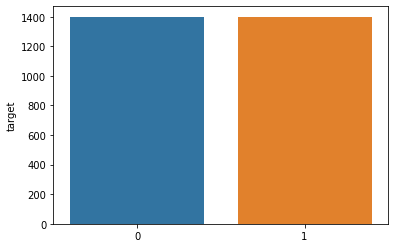

In [ ]:
import seaborn as sns
sns.barplot(x=[1, 0], y=subdata.target.value_counts())

# Load and resize image data

In [ ]:
idx = subdata.index.values[0]
X = cv2.imread('./poster/' + str(idx) + '.png')
X = cv2.resize(X, (224,224), interpolation = cv2.INTER_AREA)
X = X.reshape(1,X.shape[0], X.shape[1], X.shape[2])
for i in range(1,len(subdata)):
  if (i+1) % 500 == 0:
    print((i+1),'done.')
  idx = subdata.index.values[i]
  img = cv2.imread('./poster/' + str(idx) + '.png')
  img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
  img = img.reshape(1,img.shape[0], img.shape[1], img.shape[2])
  X = np.concatenate([X,img], axis = 0)

y = subdata.target.values
X.shape, y.shape

500 done.
1000 done.
1500 done.
2000 done.


((2000, 224, 224, 3), (2000,))

In [ ]:
# Normalize pixel values to be between 0 and 1
X = X / 255.0

# CNNs

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [ ]:
# model 1

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='preds'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    #steps_per_epoch=1100 // batch_size,
                    epochs=20,
                    batch_size = 16,
                    validation_data=(X_test, y_test)
                    #validation_steps=380 // batch_size
                    )

Epoch 1/20
100/100 [==============================] - 13s 35ms/step - loss: 2.5547 - accuracy: 0.5019 - val_loss: 0.7194 - val_accuracy: 0.4925
Epoch 2/20
100/100 [==============================] - 3s 28ms/step - loss: 0.6836 - accuracy: 0.5838 - val_loss: 0.7368 - val_accuracy: 0.5150
Epoch 3/20
100/100 [==============================] - 3s 29ms/step - loss: 0.5681 - accuracy: 0.7312 - val_loss: 0.7248 - val_accuracy: 0.5075
Epoch 4/20
100/100 [==============================] - 3s 29ms/step - loss: 0.3859 - accuracy: 0.8381 - val_loss: 1.0589 - val_accuracy: 0.4875
Epoch 5/20
100/100 [==============================] - 3s 29ms/step - loss: 0.2455 - accuracy: 0.9137 - val_loss: 0.9847 - val_accuracy: 0.5275
Epoch 6/20
100/100 [==============================] - 3s 29ms/step - loss: 0.1534 - accuracy: 0.9463 - val_loss: 1.2702 - val_accuracy: 0.5050
Epoch 7/20
100/100 [==============================] - 3s 29ms/step - loss: 0.1097 - accuracy: 0.9563 - val_loss: 1.6513 - val_accuracy: 0.490

In [ ]:
# model 2
# Create the convolutional base
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Add dense layers on top
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

# Complete architecture of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 173056)            0

In [ ]:
# Compile and train model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, 
                    batch_size = 16,
                    validation_data=(X_test, y_test))

Epoch 1/20
100/100 [==============================] - 5s 26ms/step - loss: 0.8305 - accuracy: 0.4819 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/20
100/100 [==============================] - 2s 21ms/step - loss: 0.6974 - accuracy: 0.5088 - val_loss: 0.6942 - val_accuracy: 0.4550
Epoch 3/20
100/100 [==============================] - 2s 21ms/step - loss: 0.6892 - accuracy: 0.5612 - val_loss: 0.6875 - val_accuracy: 0.5450
Epoch 4/20
100/100 [==============================] - 2s 22ms/step - loss: 0.6458 - accuracy: 0.6306 - val_loss: 0.7418 - val_accuracy: 0.5000
Epoch 5/20
100/100 [==============================] - 2s 22ms/step - loss: 0.4389 - accuracy: 0.7850 - val_loss: 0.8476 - val_accuracy: 0.5125
Epoch 6/20
100/100 [==============================] - 2s 22ms/step - loss: 0.2146 - accuracy: 0.9169 - val_loss: 1.5411 - val_accuracy: 0.5375
Epoch 7/20
100/100 [==============================] - 2s 22ms/step - loss: 0.0944 - accuracy: 0.9688 - val_loss: 3.2184 - val_accuracy: 0.5125

In [ ]:
model.save('poster_model.h5')

In [ ]:
model = models.load_model('poster_model.h5')

13/13 - 0s - loss: 5.7282 - accuracy: 0.5475 - 421ms/epoch - 32ms/step
0.5475000143051147


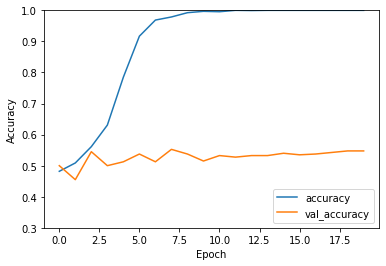

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Evaluate model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print(test_acc)

In [ ]:
# Predict and test model performance
score = model.evaluate(X_test,  y_test)

# score = model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

13/13 [==============================] - 0s 19ms/step - loss: 5.7282 - accuracy: 0.5475
Test loss: 5.728214263916016
Test accuracy: 0.5475000143051147


# CAM

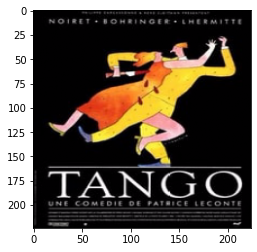

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# Prepare image for CNN
img_idx = 66

# Show image
plt.imshow(X_test[img_idx][:,:,[2,1,0]])

In [ ]:
# Image label
actual_image_type = y_test[img_idx]
print('Label:', actual_image_type)

# Image shape
test_image =np.expand_dims(X_test[img_idx], axis=0)
print('Image shape:', test_image.shape)

# Make prediction
prediction_proba = model.predict(test_image,batch_size=1)[0][0]
if prediction_proba < 0.5:
  prediction = 0
else:
  prediction = 1

# View prediction
print("Predicted class: ", prediction)
if prediction == 1:
  print("Predicted class probability: ", prediction_proba)
else:
  print("Predicted class probability: ", 1-prediction_proba)

Label: 0
Image shape: (1, 224, 224, 3)
Predicted class:  0
Predicted class probability:  1.0


grad-cam

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

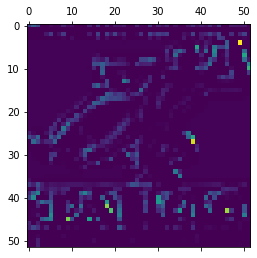

In [ ]:
# Remove last layer's softmax
model.layers[-1].activation = None

# Generate class activation heatmap
last_conv_layer_name = "conv2d_2"
heatmap = make_gradcam_heatmap(test_image, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

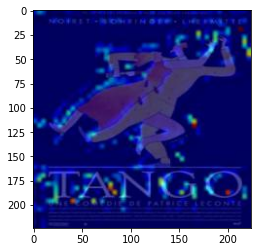

In [ ]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img[:,:,[2,1,0]]
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    img = cv2.imread(cam_path)
    plt.imshow(img[:,:,[2,1,0]])


save_and_display_gradcam(X_test[img_idx], heatmap, alpha = 0.01)

# Model Structure

In [ ]:
# Load libraries
from tensorflow.keras import models
from tensorflow.keras import layers
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model

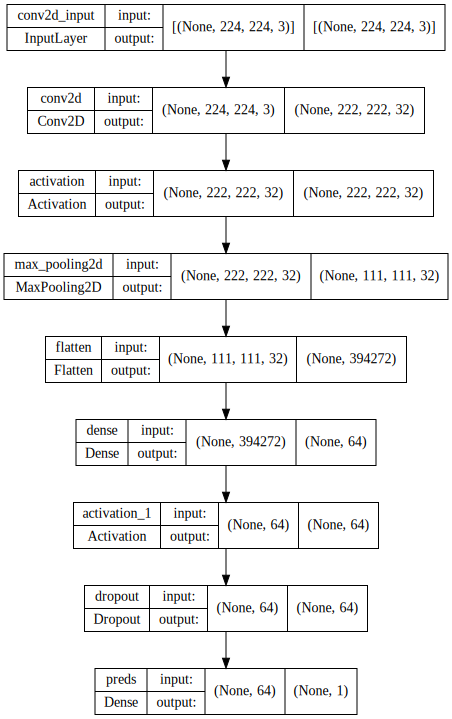

In [ ]:
SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog="dot", format="svg"))

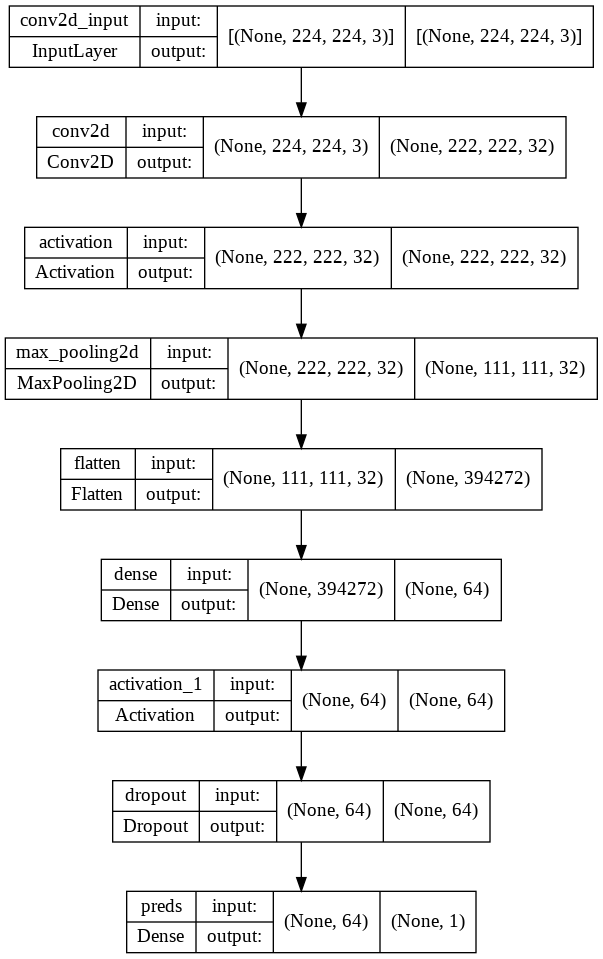

In [ ]:
plot_model(model, show_shapes=True, to_file="network2.png")